<a href="https://colab.research.google.com/github/link-kut/deeplink_public/blob/master/1.DeepLearning/09.autoencoder/autoencoder_mnist_tf20_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### https://rohitmidha23.github.io/Colab-Tricks/#show-gpu-memory-while-training

In [0]:
!pip install tensorflow-gpu==2.0.0-alpha0
!pip install gputil
!pip install psutil
!pip install humanize

In [0]:
import os, sys, humanize, psutil, GPUtil
import tensorflow as tf
#tf.debugging.set_log_device_placement(True)
print(tf.__version__)

2.0.0-alpha0


In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# Define function
def mem_report():
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print("GPU {0}: RAM Free: {1:.0f}MB | Used: {2:.0f}MB | Util {3:3.0f}% | Total {4:.0f}MB".format(
        i, 
        gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal
    ))
    print()
    
# Execute function
mem_report()

Gen RAM Free: 12.7 GB
GPU 0: RAM Free: 14950MB | Used: 129MB | Util   1% | Total 15079MB



In [0]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, Callback

import matplotlib.pyplot as plt
import numpy as np

In [0]:
(x_train, _), (x_test, _) = mnist.load_data()
 
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print(x_train.shape)
print(x_test.shape)

x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000, 784)
(10000, 784)


In [0]:
class AE(Model):
  def __init__(self, x_nodes=784, z_dim=36):
    self.x = layers.Input(shape=(x_nodes,))
    
    self.encorder_1 = layers.Dense(
        units=512, 
        kernel_initializer='glorot_normal',
        bias_initializer='zero',
        activation='sigmoid'        
    )(self.x)
    
    self.encorder_2 = layers.Dense(
        units=128, 
        kernel_initializer='glorot_normal',
        bias_initializer='zero',
        activation='sigmoid'        
    )(self.encorder_1)
    
    self.z = layers.Dense(
        units=z_dim, 
        kernel_initializer='glorot_normal',
        bias_initializer='zero',
        activation='sigmoid'
    )(self.encorder_2)
    
    self.decorder_1 = layers.Dense(
        units=128,
        kernel_initializer='glorot_normal',
        bias_initializer='zero',
        activation='sigmoid'
    )(self.z)
    
    self.decorder_2 = layers.Dense(
        units=512,
        kernel_initializer='glorot_normal',
        bias_initializer='zero',
        activation='sigmoid'
    )(self.decorder_1)
    
    self.y = layers.Dense(
        units=x_nodes,
        kernel_initializer='glorot_normal',
        bias_initializer='zero',
        activation='sigmoid'
    )(self.decorder_2)
    
    super().__init__(self.x, self.y)
    
    nesterov = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

    self.compile(
        optimizer="adam", 
        loss='mse'
    )

In [0]:
x_nodes = 784
z_dim = 36

autoencoder = AE(x_nodes, z_dim)
autoencoder.summary()

Model: "ae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 36)                4644      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               4736      
_________________________________________________________________
dense_4 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               402192   

In [0]:
encoder = Model(autoencoder.x, autoencoder.z)
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 36)                4644      
Total params: 472,228
Trainable params: 472,228
Non-trainable params: 0
_________________________________________________________________


In [0]:
class LossHistory(Callback):
    def __init__(self, model):
        self.model = model
        self.epoch = 0
        self.train_losses = []
        self.val_losses = []        

    def on_epoch_end(self, batch, logs={}):
        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        if self.epoch % 10 == 0:
            print("epoch: {0} - train loss: {1:8.6f} - val loss: {2:8.6f}".format(
                self.epoch, 
                logs.get('loss'),
                logs.get('val_loss')
            ))
#             mem_report()
        self.epoch += 1

In [0]:
history = LossHistory(model=autoencoder)
early_stopping = EarlyStopping(monitor='val_loss', patience=7)

train = autoencoder.fit(
    x=x_train, 
    y=x_train, 
    epochs=500, 
    batch_size=512,
    shuffle=True, 
    validation_data=(x_test, x_test),
    verbose=0,
    callbacks=[history, early_stopping]
)

epoch: 0 - train loss: 0.072957 - val loss: 0.067603
epoch: 10 - train loss: 0.042505 - val loss: 0.041731
epoch: 20 - train loss: 0.029910 - val loss: 0.029428
epoch: 30 - train loss: 0.025907 - val loss: 0.025520
epoch: 40 - train loss: 0.022344 - val loss: 0.022238
epoch: 50 - train loss: 0.020159 - val loss: 0.020258
epoch: 60 - train loss: 0.018568 - val loss: 0.018869
epoch: 70 - train loss: 0.017224 - val loss: 0.017435
epoch: 80 - train loss: 0.015989 - val loss: 0.016313
epoch: 90 - train loss: 0.015057 - val loss: 0.015444
epoch: 100 - train loss: 0.014295 - val loss: 0.014819
epoch: 110 - train loss: 0.013652 - val loss: 0.014223
epoch: 120 - train loss: 0.013084 - val loss: 0.013700
epoch: 130 - train loss: 0.012524 - val loss: 0.013185
epoch: 140 - train loss: 0.011936 - val loss: 0.012602
epoch: 150 - train loss: 0.011405 - val loss: 0.012093
epoch: 160 - train loss: 0.010871 - val loss: 0.011570
epoch: 170 - train loss: 0.010401 - val loss: 0.011125
epoch: 180 - train lo

In [0]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc=0)

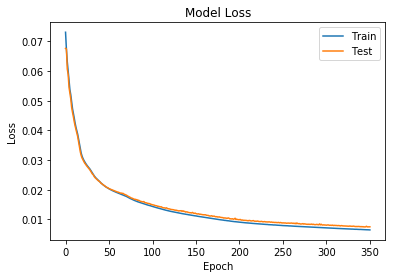

In [0]:
plot_loss(train)
plt.show()

In [0]:
def show_ae(ae, sample_size=10):
  encoded = encoder.predict(x_test)
  decoded = autoencoder.predict(x_test)
  
  plt.figure(figsize=(20, 6))
  
  for i in range(sample_size):
    ax = plt.subplot(3, sample_size, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, sample_size, i+1+sample_size)
    plt.stem(encoded[i].reshape(-1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, sample_size, i+1+sample_size*2)
    plt.imshow(decoded[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
  plt.show()

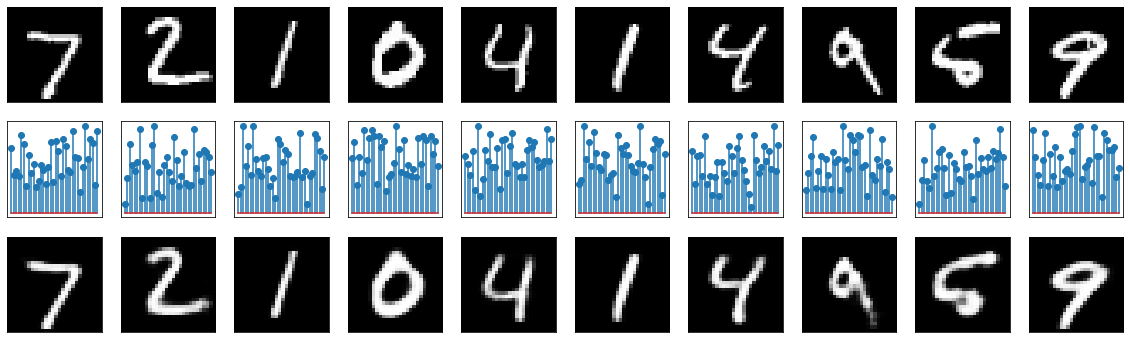

In [0]:
show_ae(autoencoder)

In [0]:
!nvidia-smi

Sat May 25 17:17:44 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    32W /  70W |    353MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
class LossHistory(Callback):
    def __init__(self, model):
        self.model = model
        self.epoch = 0
        self.train_losses = []
        self.val_losses = []        

    def on_epoch_end(self, batch, logs={}):
        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        if self.epoch % 10 == 0:
            print("epoch: {0} - train loss: {1:8.6f}, train accuracy: {2:8.6f} - val loss: {3:8.6f}, val accuracy: {4:8.6f}".format(
                self.epoch, 
                logs.get('loss'),
                logs.get('accuracy'),
                logs.get('val_loss'),
                logs.get('val_accuracy'),                
            ))
#             mem_report()
        self.epoch += 1